# RTC System Data
## Import Libraries

In [1]:
# Upgrade command
!pip install --upgrade pip

# Install Requests
!pip install requests

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1.1)


In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
import json
import requests
import datetime
import time

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from collections import namedtuple
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib.pyplot import figure

### Latitude, Longitude & TZ

In [3]:
# Specify Location (Albuquerque, NM)
latitude, longitude, tz = 35, -106.6, 'US/Mountain'

## Accessing API with Pandas
### Weather and System Data

In [4]:
# Get Weather Data from URL - June 18
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/weather/start/2020-06-17/end/2020-06-18/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
weather_df = pd.DataFrame(response.json())
weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,RainDailyAccumilation,RelativeHumidity,TmStamp,WindDirection,WindSpeed
0,25.120001,-6.394786,0.295116,-6.266078,0.0,28.620001,1592352060000,164.199997,3.067
1,25.110001,-6.378025,0.321420,-6.172170,0.0,28.690001,1592352120000,164.300003,3.564
2,25.120001,-6.246201,0.331167,-6.198898,0.0,28.410000,1592352180000,160.100006,3.781
3,25.120001,-6.397074,0.263382,-6.161370,0.0,28.430000,1592352240000,165.300003,3.367
4,25.180000,-5.817014,0.148604,-6.148628,0.0,28.219999,1592352300000,161.699997,3.628


In [5]:
# Drop unnecessary data
weather_df.drop(['RainDailyAccumilation', 'RelativeHumidity', 'WindDirection', 'WindSpeed'], axis=1, inplace=True)

weather_df.head()

,AmbientTemp,DiffuseIrrad,DirectIrrad,GlobalIrrad,TmStamp
0,25.120001,-6.394786,0.295116,-6.266078,1592352060000
1,25.110001,-6.378025,0.321420,-6.172170,1592352120000
2,25.120001,-6.246201,0.331167,-6.198898,1592352180000
3,25.120001,-6.397074,0.263382,-6.161370,1592352240000
4,25.180000,-5.817014,0.148604,-6.148628,1592352300000


In [6]:
weather_df.rename(columns={'TmStamp':'TimeStamp', 'GlobalIrrad':'GHI', 'DirectIrrad':'DNI', 'DiffuseIrrad':'DHI'}, inplace=True)

In [7]:
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,25.120001,-6.394786,0.295116,-6.266078,1592352060000
1,25.110001,-6.378025,0.321420,-6.172170,1592352120000
2,25.120001,-6.246201,0.331167,-6.198898,1592352180000
3,25.120001,-6.397074,0.263382,-6.161370,1592352240000
4,25.180000,-5.817014,0.148604,-6.148628,1592352300000


In [8]:
# Examine the types of the column labels
all(isinstance(column, str) for column in weather_df.columns)

True

In [9]:
weather_df['TimeStamp'] =  pd.to_datetime(weather_df['TimeStamp']/1000, unit='s')
weather_df.head()

,AmbientTemp,DHI,DNI,GHI,TimeStamp
0,25.120001,-6.394786,0.295116,-6.266078,2020-06-17 00:01:00
1,25.110001,-6.378025,0.321420,-6.172170,2020-06-17 00:02:00
2,25.120001,-6.246201,0.331167,-6.198898,2020-06-17 00:03:00
3,25.120001,-6.397074,0.263382,-6.161370,2020-06-17 00:04:00
4,25.180000,-5.817014,0.148604,-6.148628,2020-06-17 00:05:00


In [10]:
# TimeStamp as Index
weather_df.set_index('TimeStamp', inplace=True)
weather_df.head()

,AmbientTemp,DHI,DNI,GHI
TimeStamp,,,,
2020-06-17 00:01:00,25.120001,-6.394786,0.295116,-6.266078
2020-06-17 00:02:00,25.110001,-6.378025,0.321420,-6.172170
2020-06-17 00:03:00,25.120001,-6.246201,0.331167,-6.198898
2020-06-17 00:04:00,25.120001,-6.397074,0.263382,-6.161370
2020-06-17 00:05:00,25.180000,-5.817014,0.148604,-6.148628


In [11]:
# Weather Keys
print("Keys of weather_df: \n{}".format(weather_df.keys()))

Keys of weather_df: 
Index(['AmbientTemp', 'DHI', 'DNI', 'GHI'], dtype='object')


In [12]:
# Analyzing Data - June 17
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
weather_df.describe()

,AmbientTemp,DHI,DNI,GHI
count,1439.000000,1439.000000,1439.000000,1439.000000
mean,28.324816,29.288142,492.147159,368.654717
std,4.857576,33.894093,444.661533,409.467026
min,19.840000,-12.080256,-0.420807,-7.609949
25%,24.070000,-7.168710,0.163147,-6.434348
50%,28.719999,39.343540,643.719543,180.610168
75%,32.910000,61.764153,951.056000,784.102386
max,35.590000,82.902252,1015.430969,1059.342285


In [13]:
weather_df_slice = weather_df.iloc[::5] 

## System

In [14]:
# Get System Data from URL - June 17
URL = "https://pv-dashboard.sandia.gov/api/v1.0/location/Albuquerque/data/system/start/2020-06-17/end/2020-06-18/key/ZhWJxS48oMpRm1"

response = requests.get(url=URL)
system_df = pd.DataFrame(response.json())
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TmStamp
0,24.291666,-2.317497,0.0,0.0,-0.04425,2.433333,-2.496397,0.006,1.833333,0.0,1592352060000
1,24.275000,-2.317497,0.0,0.0,-0.04325,2.450000,-2.569015,0.006,1.666667,0.0,1592352120000
2,24.291666,-2.317497,0.0,0.0,-0.04500,2.350000,-2.422043,0.006,1.583333,0.0,1592352180000
3,24.316666,-2.317497,0.0,0.0,-0.04500,2.216667,-2.788946,0.006,1.583333,0.0,1592352240000
4,24.400000,-2.317497,0.0,0.0,-0.04500,2.200000,-2.422271,0.006,1.600000,0.0,1592352300000


In [15]:
# System Keys
print("Keys of system_df: \n{}".format(system_df.keys()))

Keys of system_df: 
Index(['AmbientTemp', 'PyranometerIrrad', 'RefCell1Irrad', 'RefCell2Irrad',
       'Sys1Idc', 'Sys1Vdc', 'Sys1Wac', 'Sys2Idc', 'Sys2Vdc', 'Sys2Wac',
       'TmStamp'],
      dtype='object')


In [16]:
system_df.rename(columns={'TmStamp':'TimeStamp'}, inplace=True)

In [17]:
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,24.291666,-2.317497,0.0,0.0,-0.04425,2.433333,-2.496397,0.006,1.833333,0.0,1592352060000
1,24.275000,-2.317497,0.0,0.0,-0.04325,2.450000,-2.569015,0.006,1.666667,0.0,1592352120000
2,24.291666,-2.317497,0.0,0.0,-0.04500,2.350000,-2.422043,0.006,1.583333,0.0,1592352180000
3,24.316666,-2.317497,0.0,0.0,-0.04500,2.216667,-2.788946,0.006,1.583333,0.0,1592352240000
4,24.400000,-2.317497,0.0,0.0,-0.04500,2.200000,-2.422271,0.006,1.600000,0.0,1592352300000


In [18]:
# Examine the types of the column labels
all(isinstance(column, str) for column in system_df.columns)

True

In [19]:
system_df['TimeStamp'] =  pd.to_datetime(system_df['TimeStamp']/1000, unit='s')
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac,TimeStamp
0,24.291666,-2.317497,0.0,0.0,-0.04425,2.433333,-2.496397,0.006,1.833333,0.0,2020-06-17 00:01:00
1,24.275000,-2.317497,0.0,0.0,-0.04325,2.450000,-2.569015,0.006,1.666667,0.0,2020-06-17 00:02:00
2,24.291666,-2.317497,0.0,0.0,-0.04500,2.350000,-2.422043,0.006,1.583333,0.0,2020-06-17 00:03:00
3,24.316666,-2.317497,0.0,0.0,-0.04500,2.216667,-2.788946,0.006,1.583333,0.0,2020-06-17 00:04:00
4,24.400000,-2.317497,0.0,0.0,-0.04500,2.200000,-2.422271,0.006,1.600000,0.0,2020-06-17 00:05:00


In [20]:
system_df.drop(system_df.index[range(0, 360)], axis=0, inplace=True)

In [21]:
system_df.drop(system_df.index[range(1019, 1079)], axis=0, inplace=True)

In [22]:
# TimeStamp as Index
system_df.set_index('TimeStamp', inplace=True)
system_df.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-17 06:01:00,21.958330,47.508686,36.810078,35.902859,0.26250,328.166656,73.382515,0.28400,360.833344,80.860939
2020-06-17 06:02:00,21.908333,47.508686,37.128185,36.195427,0.26700,326.516663,74.483788,0.28725,360.500000,81.740601
2020-06-17 06:03:00,21.916664,46.156815,37.431194,36.444157,0.26775,329.333344,75.056236,0.28975,360.833344,83.049721
2020-06-17 06:04:00,21.849998,43.839314,37.673397,36.736412,0.27150,327.216675,76.151237,0.29325,360.550018,83.262245
2020-06-17 06:05:00,21.824999,42.294319,37.976704,36.985279,0.27750,323.033325,76.661568,0.29425,360.916656,84.211128


In [23]:
# Analyzing Data
system_df.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000,1019.000000
mean,29.940693,448.804284,429.782729,428.380051,3.528556,266.344663,1100.058254,3.553342,266.314486,1127.549144
std,3.665043,388.941691,382.878881,383.670441,3.161724,129.881594,965.565941,3.136206,135.002926,979.749779
min,21.641665,-4.731556,0.000000,0.000000,-0.045000,2.200000,-2.791782,0.006000,1.400000,0.000000
25%,27.116667,22.740438,25.935030,25.582844,0.171500,304.008331,32.816826,0.200000,314.449997,40.847248
50%,30.416666,427.771271,392.693878,388.514282,3.243000,323.750000,1071.712646,3.253500,326.683319,1093.854126
75%,33.233334,846.900269,827.492493,826.203430,6.816500,339.475006,2108.573120,6.820625,342.316650,2153.237915
max,35.716667,1012.263367,989.122620,990.938049,8.160250,396.933319,2484.601318,8.142500,373.283325,2538.154053


In [24]:
system_df_slice = system_df.iloc[::5] 

In [25]:
system_df_slice.head()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
TimeStamp,,,,,,,,,,
2020-06-17 06:01:00,21.958330,47.508686,36.810078,35.902859,0.26250,328.166656,73.382515,0.28400,360.833344,80.860939
2020-06-17 06:06:00,21.800001,41.714947,38.355915,37.380264,0.28125,323.766663,77.684677,0.30225,357.916656,82.516823
2020-06-17 06:11:00,22.208334,42.873692,40.759895,38.985836,0.30575,329.166656,87.170280,0.33125,358.583344,96.700714
2020-06-17 06:16:00,22.000000,54.074932,47.319027,43.187244,0.31950,349.516632,98.814003,0.37125,361.800018,111.425316
2020-06-17 06:21:00,21.699999,78.988022,44.710632,45.060856,0.33950,363.716644,110.202690,0.42975,364.599976,133.224976


In [26]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,29.939052,448.519916,429.406829,427.893406,3.524053,266.913555,1099.105298,3.550692,266.876956,1126.547558
std,3.667589,389.554590,383.570388,384.407846,3.166182,129.987831,967.372915,3.142214,134.876013,981.643462
min,21.699999,-4.634994,0.000000,0.000000,-0.045000,2.200000,-2.719036,0.006000,1.400000,0.000000
25%,27.141666,24.261295,27.030810,26.645077,0.180937,304.029167,36.027313,0.207062,314.920822,44.737019
50%,30.437499,426.371155,391.628265,387.605957,3.238125,324.291672,1066.585388,3.252375,325.824997,1085.054504
75%,33.279166,843.906891,827.217346,821.471771,6.794437,339.541672,2102.552979,6.799750,342.308304,2150.241577
max,35.483334,1011.877136,988.088196,989.725342,8.113250,396.933319,2484.601318,8.142500,372.949982,2534.447754


# Weather and System Plot
## Weather June 17

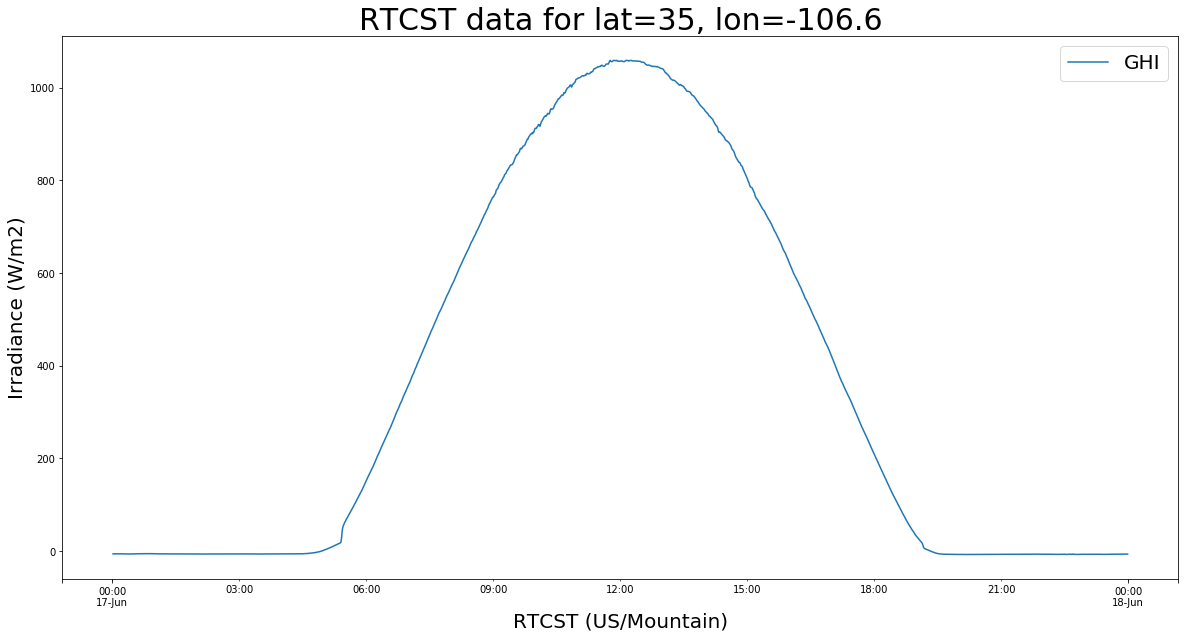

In [27]:
# Plot GHI
irrad_var = ['GHI']
weather_df[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

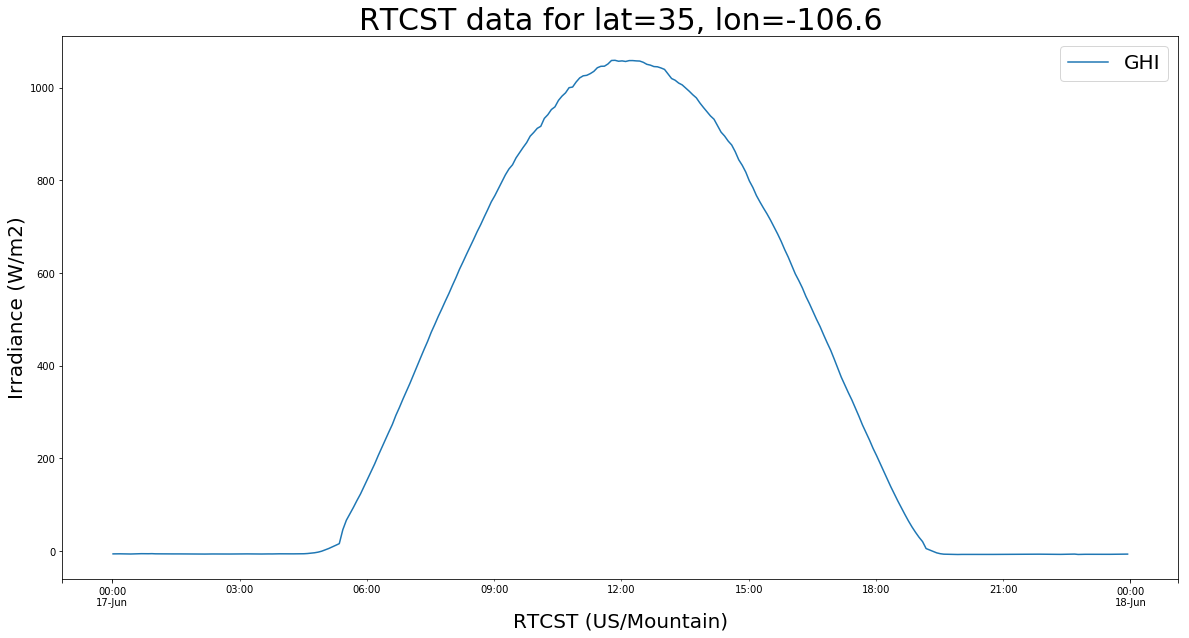

In [28]:
# Plot GHI
irrad_var = ['GHI']
weather_df_slice[irrad_var].plot(figsize=(20,10));
plt.ylabel('Irradiance (W/m2)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## System PIV June 17

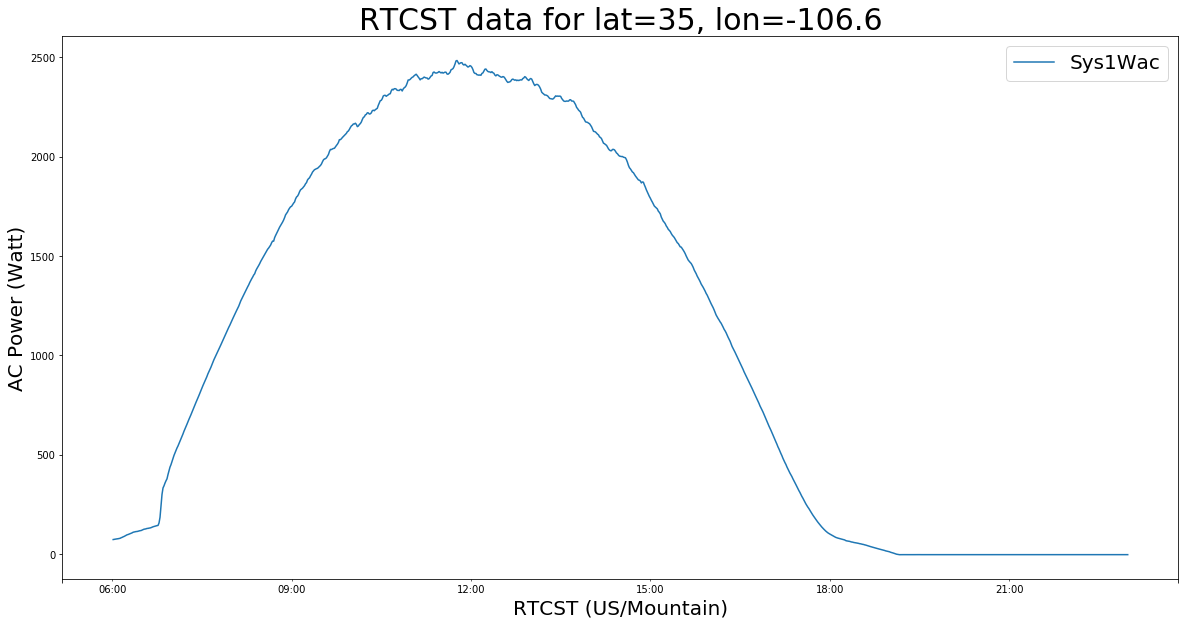

In [29]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

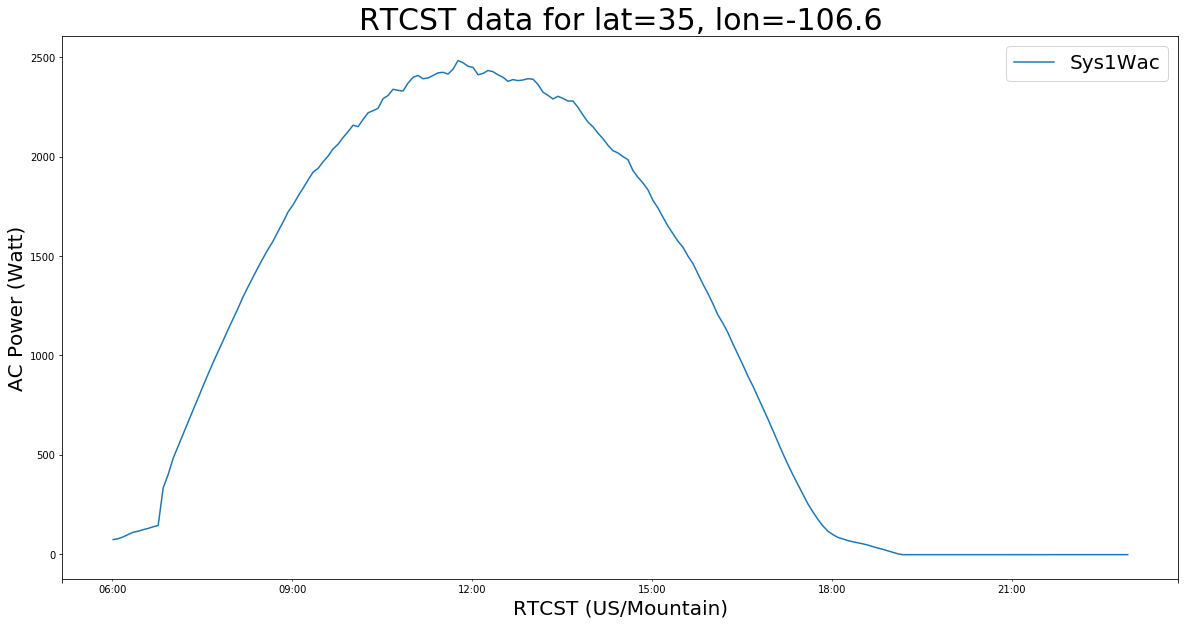

In [30]:
# Plot AC Power Output
sys1i_var = ['Sys1Wac']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

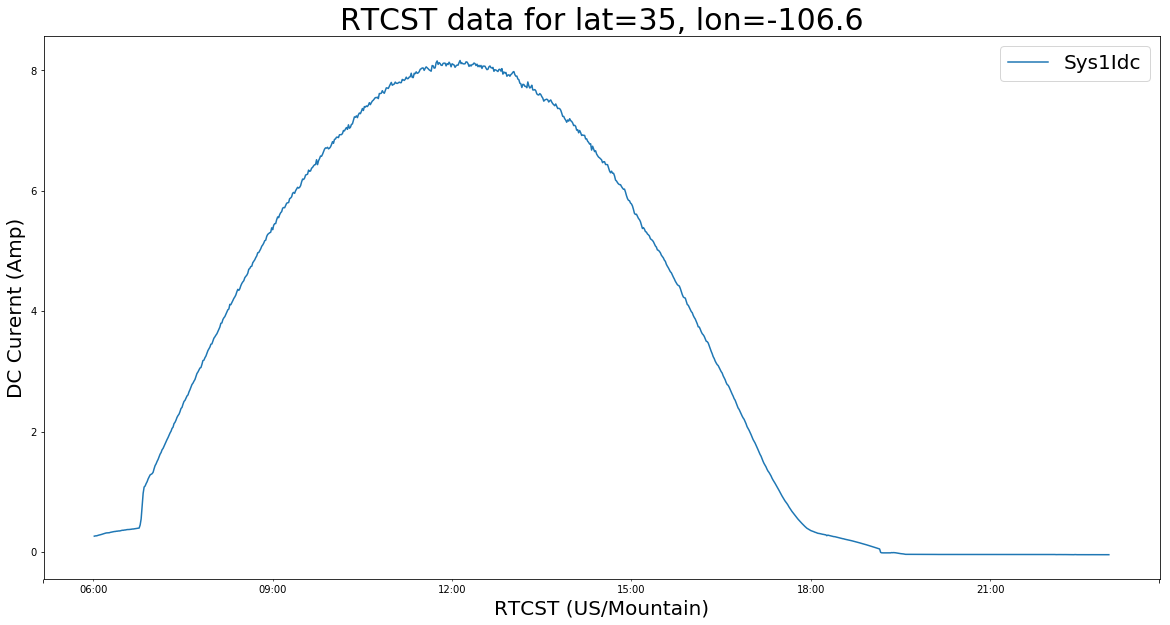

In [31]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

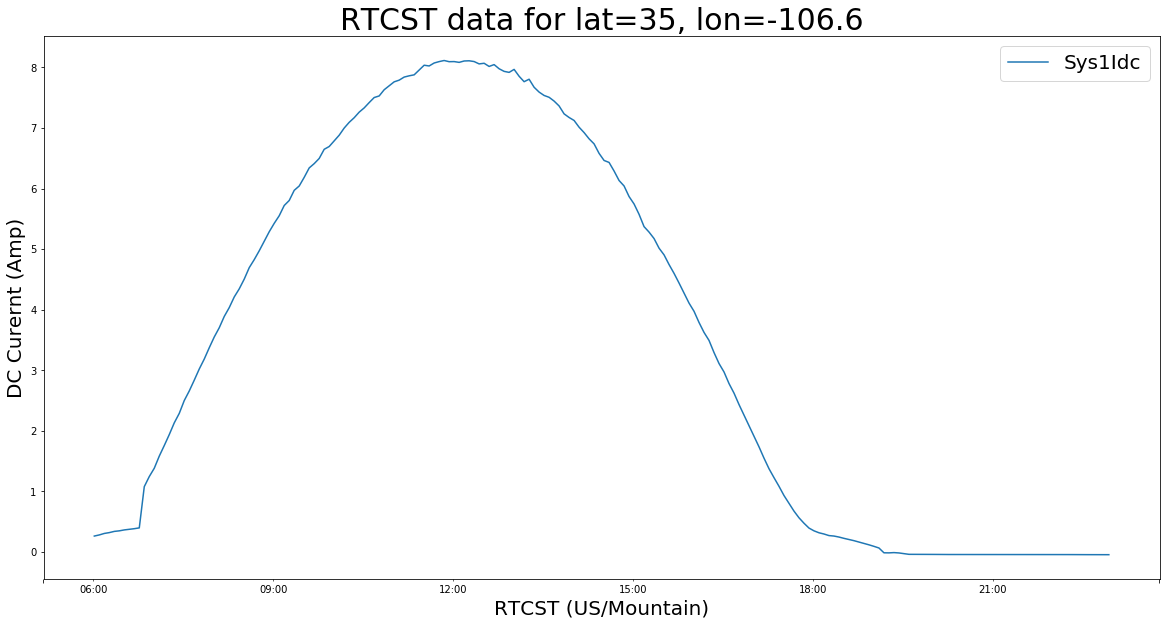

In [32]:
# Plot DC Current
sys1i_var = ['Sys1Idc']
system_df_slice[sys1i_var].plot(figsize=(20,10));
plt.ylabel('DC Curernt (Amp)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

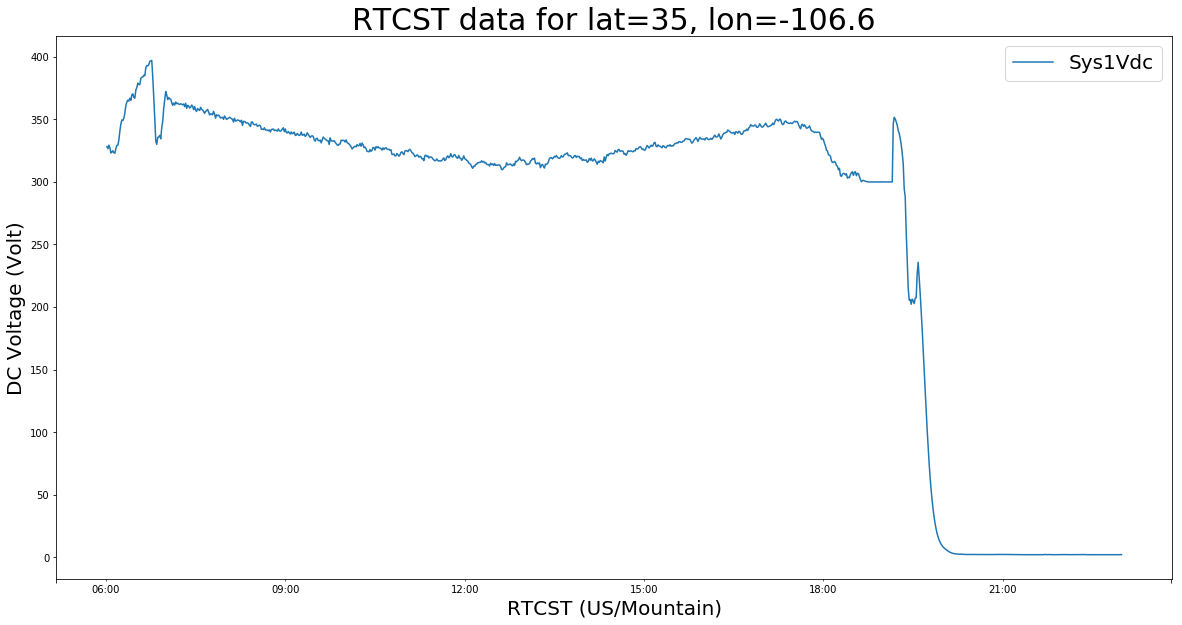

In [33]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

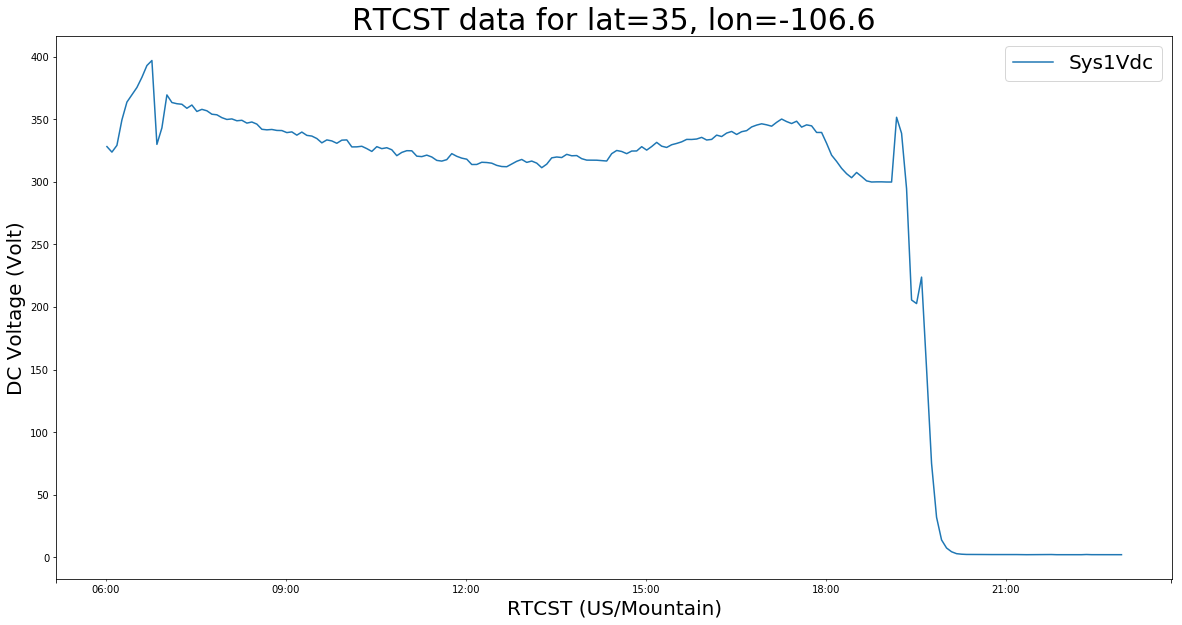

In [34]:
# Plot DC Voltage
sys1v_var = ['Sys1Vdc']
system_df_slice[sys1v_var].plot(figsize=(20,10));
plt.ylabel('DC Voltage (Volt)',size=20);
plt.xlabel('RTCST ({})'.format(tz),size=20);
plt.title('RTCST data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

## Read CSV's

In [35]:
# Read HRRR Irradiance CSV
hrrr_df = pd.read_csv('HRRR June 18.csv')
print("Keys of hrrr_df: \n{}".format(hrrr_df.keys()))

Keys of hrrr_df: 
Index(['Unnamed: 0', 'ghi', 'dni', 'dhi'], dtype='object')


In [36]:
hrrr_df.describe()

,ghi,dni,dhi
count,18.000000,18.000000,18.000000
mean,451.692550,461.190369,121.129141
std,382.448268,320.344074,99.772250
min,0.000000,0.000000,0.000000
25%,37.766015,66.590457,24.226460
50%,450.539004,662.651866,107.102123
75%,820.523477,714.841841,206.060962
max,974.040795,731.931640,280.432297


In [37]:
hrrr_df.head()

,Unnamed: 0,ghi,dni,dhi
0,2020-06-17 06:00:00-06:00,0.354872,0.000000,0.354872
1,2020-06-17 07:00:00-06:00,119.726626,266.361830,65.568407
2,2020-06-17 08:00:00-06:00,323.150247,572.171940,95.072696
3,2020-06-17 09:00:00-06:00,525.973962,702.137986,117.142055
4,2020-06-17 10:00:00-06:00,705.131775,731.061555,162.856443


In [38]:
# Read Forecast AC Power CSV
ac_df = pd.read_csv('AC June 18.csv')
print("Keys of ac_df: \n{}".format(ac_df.keys()))

Keys of ac_df: 
Index(['2020-06-17 06:00:00-06:00', '-1.56'], dtype='object')


In [39]:
ac_df.head()

,2020-06-17 06:00:00-06:00,-1.56
0,2020-06-17 06:05:00-06:00,-1.560000
1,2020-06-17 06:10:00-06:00,-1.560000
2,2020-06-17 06:15:00-06:00,-1.560000
3,2020-06-17 06:20:00-06:00,20.666287
4,2020-06-17 06:25:00-06:00,83.837967


In [40]:
# TimeStamp as Index
ac_df.set_index('2020-06-17 06:00:00-06:00', inplace=True)
ac_df.head()

,-1.56
2020-06-17 06:00:00-06:00,
2020-06-17 06:05:00-06:00,-1.560000
2020-06-17 06:10:00-06:00,-1.560000
2020-06-17 06:15:00-06:00,-1.560000
2020-06-17 06:20:00-06:00,20.666287
2020-06-17 06:25:00-06:00,83.837967


In [41]:
ac_df.rename(columns={'-1.56':'AC Power'}, inplace=True)
ac_df.head()

,AC Power
2020-06-17 06:00:00-06:00,
2020-06-17 06:05:00-06:00,-1.560000
2020-06-17 06:10:00-06:00,-1.560000
2020-06-17 06:15:00-06:00,-1.560000
2020-06-17 06:20:00-06:00,20.666287
2020-06-17 06:25:00-06:00,83.837967


In [42]:
ac_df.describe()

,AC Power
count,204.000000
mean,1740.508943
std,1095.539681
min,-1.560000
25%,424.265991
50%,2385.970853
75%,2624.184273
max,2709.228295


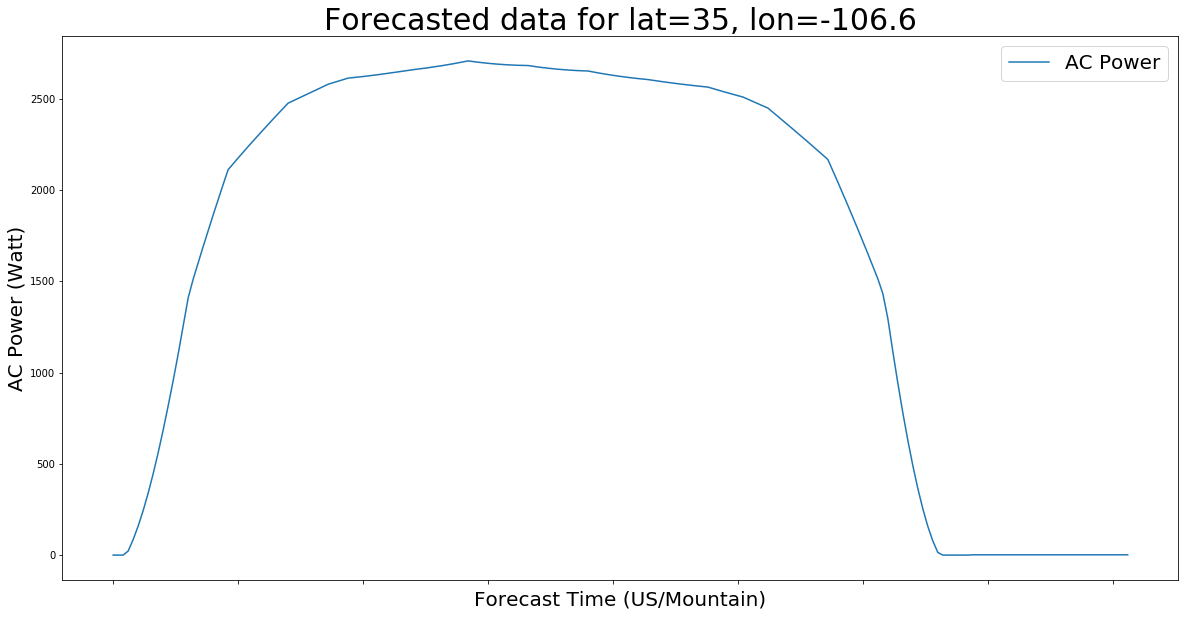

In [43]:
# Plot AC Power
forecast_ac = ['AC Power']
ac_df[forecast_ac].plot(figsize=(20,10), label = 'AC Power');
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Forecast Time ({})'.format(tz),size=20);
plt.title('Forecasted data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [44]:
# Read Forecast DC Power CSV
dc_df = pd.read_csv('DC June 18.csv')
print("Keys of dc_df: \n{}".format(dc_df.keys()))

Keys of dc_df: 
Index(['Unnamed: 0', 'i_sc', 'i_mp', 'v_oc', 'v_mp', 'p_mp', 'i_x', 'i_xx'], dtype='object')


In [45]:
dc_df.describe()

,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,3.201845,2.850796,654.452864,516.196148,1836.350973,3.127950,2.046127
std,2.009690,1.786381,310.425197,253.393027,1150.159872,1.963981,1.265985
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.825774,0.743645,773.164971,629.621926,454.918451,0.804691,0.584447
50%,4.391403,3.912304,801.624441,638.330641,2513.701602,4.289873,2.811386
75%,4.862801,4.321444,815.800982,649.668397,2765.723878,4.751885,3.070281
max,4.910893,4.367439,823.346199,675.292949,2855.495262,4.799066,3.095987


In [46]:
dc_df.head()

,Unnamed: 0,i_sc,i_mp,v_oc,v_mp,p_mp,i_x,i_xx
0,2020-06-17 06:00:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-06-17 06:05:00-06:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-06-17 06:10:00-06:00,0.004515,0.004086,537.404358,0.000000,0.000000,0.004398,0.003266
3,2020-06-17 06:15:00-06:00,0.106528,0.096378,698.579113,479.423426,46.205685,0.103756,0.076852
4,2020-06-17 06:20:00-06:00,0.209826,0.189768,731.881898,550.945761,104.551946,0.204381,0.150961


### Merge DataFrames

In [47]:
# Clear Index
ac_df=ac_df.reset_index()
system_df_slice=system_df_slice.reset_index()

In [48]:
ac_df.head()

,2020-06-17 06:00:00-06:00,AC Power
0,2020-06-17 06:05:00-06:00,-1.560000
1,2020-06-17 06:10:00-06:00,-1.560000
2,2020-06-17 06:15:00-06:00,-1.560000
3,2020-06-17 06:20:00-06:00,20.666287
4,2020-06-17 06:25:00-06:00,83.837967


In [49]:
ac_df.describe()

,AC Power
count,204.000000
mean,1740.508943
std,1095.539681
min,-1.560000
25%,424.265991
50%,2385.970853
75%,2624.184273
max,2709.228295


In [50]:
system_df_slice.head()

,TimeStamp,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
0,2020-06-17 06:01:00,21.958330,47.508686,36.810078,35.902859,0.26250,328.166656,73.382515,0.28400,360.833344,80.860939
1,2020-06-17 06:06:00,21.800001,41.714947,38.355915,37.380264,0.28125,323.766663,77.684677,0.30225,357.916656,82.516823
2,2020-06-17 06:11:00,22.208334,42.873692,40.759895,38.985836,0.30575,329.166656,87.170280,0.33125,358.583344,96.700714
3,2020-06-17 06:16:00,22.000000,54.074932,47.319027,43.187244,0.31950,349.516632,98.814003,0.37125,361.800018,111.425316
4,2020-06-17 06:21:00,21.699999,78.988022,44.710632,45.060856,0.33950,363.716644,110.202690,0.42975,364.599976,133.224976


In [51]:
system_df_slice.describe()

,AmbientTemp,PyranometerIrrad,RefCell1Irrad,RefCell2Irrad,Sys1Idc,Sys1Vdc,Sys1Wac,Sys2Idc,Sys2Vdc,Sys2Wac
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,29.939052,448.519916,429.406829,427.893406,3.524053,266.913555,1099.105298,3.550692,266.876956,1126.547558
std,3.667589,389.554590,383.570388,384.407846,3.166182,129.987831,967.372915,3.142214,134.876013,981.643462
min,21.699999,-4.634994,0.000000,0.000000,-0.045000,2.200000,-2.719036,0.006000,1.400000,0.000000
25%,27.141666,24.261295,27.030810,26.645077,0.180937,304.029167,36.027313,0.207062,314.920822,44.737019
50%,30.437499,426.371155,391.628265,387.605957,3.238125,324.291672,1066.585388,3.252375,325.824997,1085.054504
75%,33.279166,843.906891,827.217346,821.471771,6.794437,339.541672,2102.552979,6.799750,342.308304,2150.241577
max,35.483334,1011.877136,988.088196,989.725342,8.113250,396.933319,2484.601318,8.142500,372.949982,2534.447754


In [52]:
# I guess it will make plotting easier
system=system_df_slice['Sys1Wac']
ac_df['System']=system
ac_df.head()

,2020-06-17 06:00:00-06:00,AC Power,System
0,2020-06-17 06:05:00-06:00,-1.560000,73.382515
1,2020-06-17 06:10:00-06:00,-1.560000,77.684677
2,2020-06-17 06:15:00-06:00,-1.560000,87.170280
3,2020-06-17 06:20:00-06:00,20.666287,98.814003
4,2020-06-17 06:25:00-06:00,83.837967,110.202690


In [53]:
# TimeStamp as Index
ac_df.set_index('2020-06-17 06:00:00-06:00', inplace=True)
ac_df.head()

,AC Power,System
2020-06-17 06:00:00-06:00,,
2020-06-17 06:05:00-06:00,-1.560000,73.382515
2020-06-17 06:10:00-06:00,-1.560000,77.684677
2020-06-17 06:15:00-06:00,-1.560000,87.170280
2020-06-17 06:20:00-06:00,20.666287,98.814003
2020-06-17 06:25:00-06:00,83.837967,110.202690


In [54]:
# Examine the column labels
all(isinstance(column, str) for column in ac_df.columns)

True

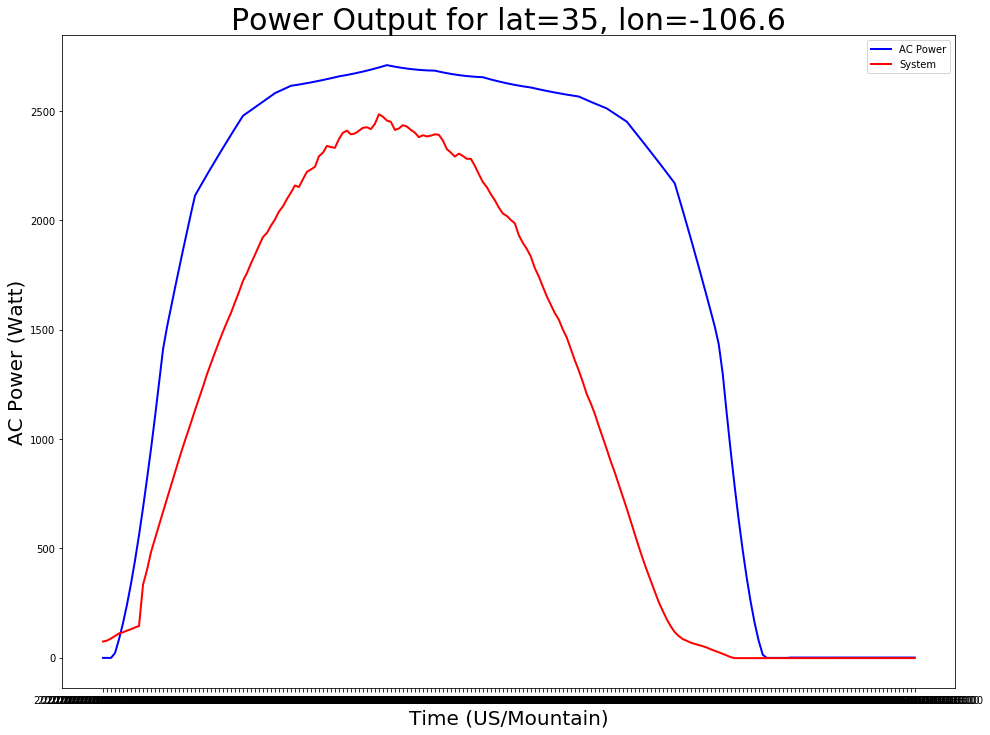

In [55]:
plt.figure(figsize=(16,12))
plt.ylabel('AC Power (Watt)',size=20);
plt.xlabel('Time ({})'.format(tz),size=20);
plt.title('Power Output for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.plot('AC Power', data=ac_df, marker='', color='blue', linewidth=2);
plt.plot('System', data=ac_df, marker='', color='red', linewidth=2);
plt.legend();

## Error
### Mean Square Error

In [56]:
y_true= system_df_slice['Sys1Wac']
y_pred= ac_df['AC Power']
print('Mean Square Error:\n',mean_squared_error(y_true, y_pred))

Mean Square Error:
 771601.3419076736
